# Imports, setup and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


We'll load the ```MultiSourceDataset``` class, which takes care of lazily loading the sources and will allows us to study their properties.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
from multi_sources.data_processing.utils import read_sources
from multi_sources.data_processing.multi_source_dataset import MultiSourceDataset

Note: as of now, this notebook was run with only the preprocessed for 2016 and 2017. As satellites may have their mission start or end at any point during the period covered by the dataset, the available sources vary over time.

# Microwave images

In [3]:
with open('conf/sources/all_microwave.yaml', 'r') as f:
    sources = read_sources(yaml.safe_load(f))
dataset = MultiSourceDataset(sources)

tc_primed.microwave.AMSR2_GCOMW1.S1: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S2: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S3: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S4: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S5: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S6: Found 2 storm data files.
tc_primed.microwave.ATMS_NOAA20.S1: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S2: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S3: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S4: Found 1 storm data files.
tc_primed.microwave.ATMS_NPP.S1: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S2: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S3: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S4: Found 2 storm data files.
tc_primed.microwave.GMI_GPM.S1: Found 2 storm data files.
tc_primed.microwave.GMI_GPM.S2: Found 2 storm data files.
tc_primed.microwave.MH

Let's check the total number of images in the dataset:

In [4]:
len(dataset)

53724

Note: at this point, none of the images are actually loaded in memory, but the dataset keeps a ```DataFrame``` of all images that *can* be accessed:

In [7]:
df = dataset.df
df.head()

,SID,time,season,basin,cyclone_number,source,source_name
789,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
781,2016AL1,2016-01-07 17:40:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
786,2016AL1,2016-01-09 06:27:09,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
783,2016AL1,2016-01-10 05:31:10,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
790,2016AL1,2016-01-10 16:32:10,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1


## Repartition by source

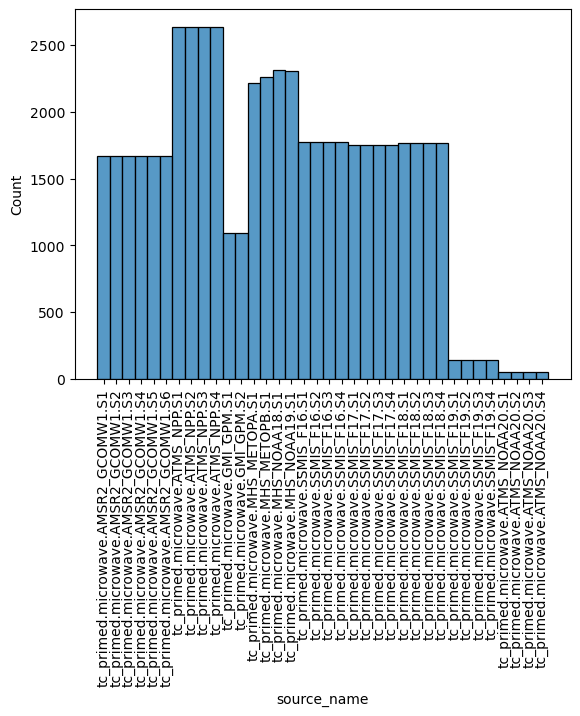

In [11]:
sns.histplot(df, x='source_name')
plt.xticks(rotation=90)
plt.show()

Clearly the amount of available overpasses heavily varies with the source. The main reason is that the number of unique frequencies scanned is inequal between the sensors.  
It might also be partly explained by the times some satellites were sent into orbit, or had their missions ended. Besides, the satellites don't have the same orbits and some of them might more frequently orbit over cyclone-prone areas.

## Repartition by satellite over time

In [34]:
# Compute the number of overpasses per month for each source
month = df.time.dt.to_period('M')
sat = df.source_name.apply(lambda s: s.split('.')[-2].split('_')[0])
monthly_obs = df.groupby([sat, month])['SID'].count().rename('Monthly overpasses').reset_index()
monthly_obs['time'] = monthly_obs.time.dt.to_timestamp()

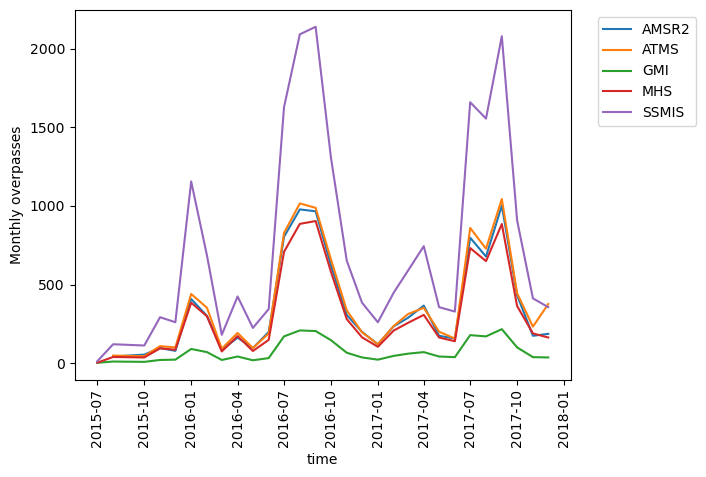

In [35]:
sns.lineplot(monthly_obs, x='time', y='Monthly overpasses', hue='source_name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Let's also look at the counts per sensor and satellite:

In [38]:
sensat = df.source_name.apply(lambda s: s.split('.')[-2])
monthly_obs = df.groupby([sensat, month])['SID'].count().rename('Monthly overpasses').reset_index()
monthly_obs['time'] = monthly_obs.time.dt.to_timestamp()

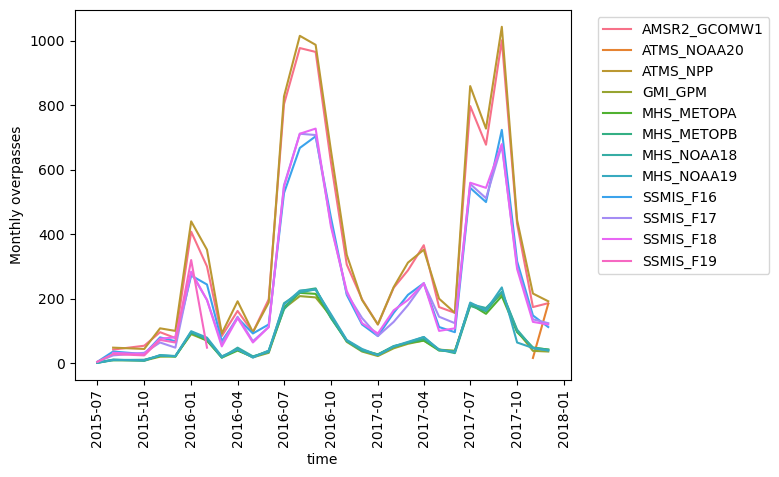

In [39]:
sns.lineplot(monthly_obs, x='time', y='Monthly overpasses', hue='source_name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

The observations from the satellite/sensor pair ```SSMIS_F19``` abruptly end in early 2016.